In [1]:
library(igraph)
# install.packages("gsubfn")
library(gsubfn) #allows unpacking multiple return values from functions without using a dummy variable (but needs a fresh R session to work, intitially)

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'gsubfn' was built under R version 3.6.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.6.3"

In [2]:
#install.packages("resample")
library('resample')


Attaching package: 'resample'

The following object is masked from 'package:gsubfn':

    cat0



In [3]:
library('Matrix')
library('pracma')

Warning message:
"package 'pracma' was built under R version 3.6.3"
Attaching package: 'pracma'

The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu



In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
logspace <- function( d1, d2, n) exp(log(10)*seq(d1, d2, length.out=n))

# Part 2

## Q1

## (a)

In [6]:
g <- sample_gnp(n=1000, p=0.01, directed=F)

## (b)

In [7]:
get_freq_distr = function(vec){
    return ( list(as.numeric(names(table(vec))), as.vector(table(vec))) ) 
}

In [8]:
get_gcc = function(g){
    if(is_connected(g)) return (g)
    else{
        g.components <- clusters(g)
        gcc_idx <- which.max(g.components$csize)
        gcc <- induced.subgraph(g, which(g.components$membership == gcc_idx))
        return (gcc)
    }
}

In [9]:
perform_random_walk = function(g, steps=100, iters=1000){
    shortest_dists = matrix(NA, nrow=iters, ncol=steps)
    terminal_node_deg = array(NA, iters)
    for(i in 1:iters){
        gcc <- get_gcc(g)
        #print(V(gcc))
        start_vert = sample(V(gcc), 1)
        vert_seq = random_walk(gcc, start_vert, steps)
        terminal_node_deg[i] = degree(gcc, vert_seq[length(vert_seq)])
        #distances(gcc, start_vert, vert_seq)
        #print(vert_seq)
        shortest_dists[i,] = shortest.paths(gcc, vert_seq, start_vert)
    }
    return (list(shortest_dists, terminal_node_deg))
}

In [10]:
list[shortest_dists, terminal_node_deg] <- perform_random_walk(g)

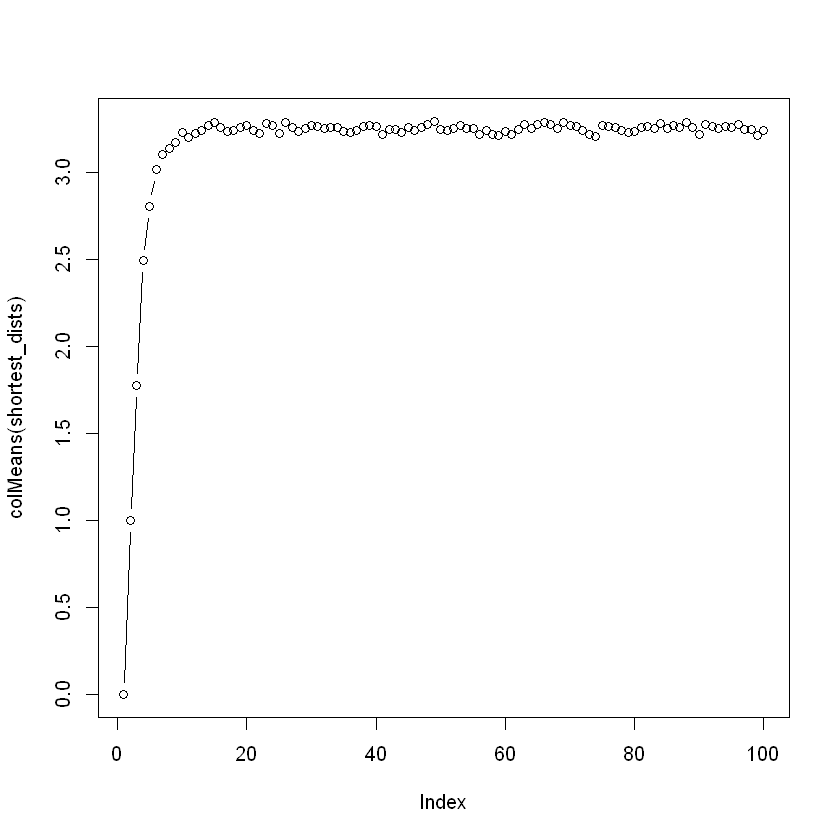

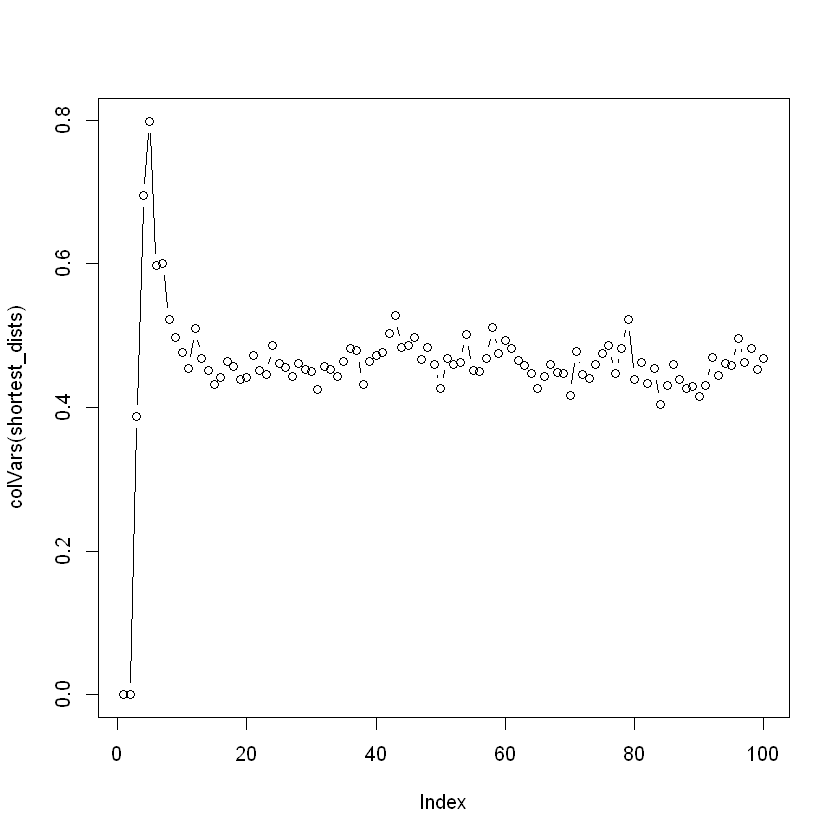

In [11]:
plot(colMeans(shortest_dists), type="b")
plot(colVars(shortest_dists), type="b")

## (c)

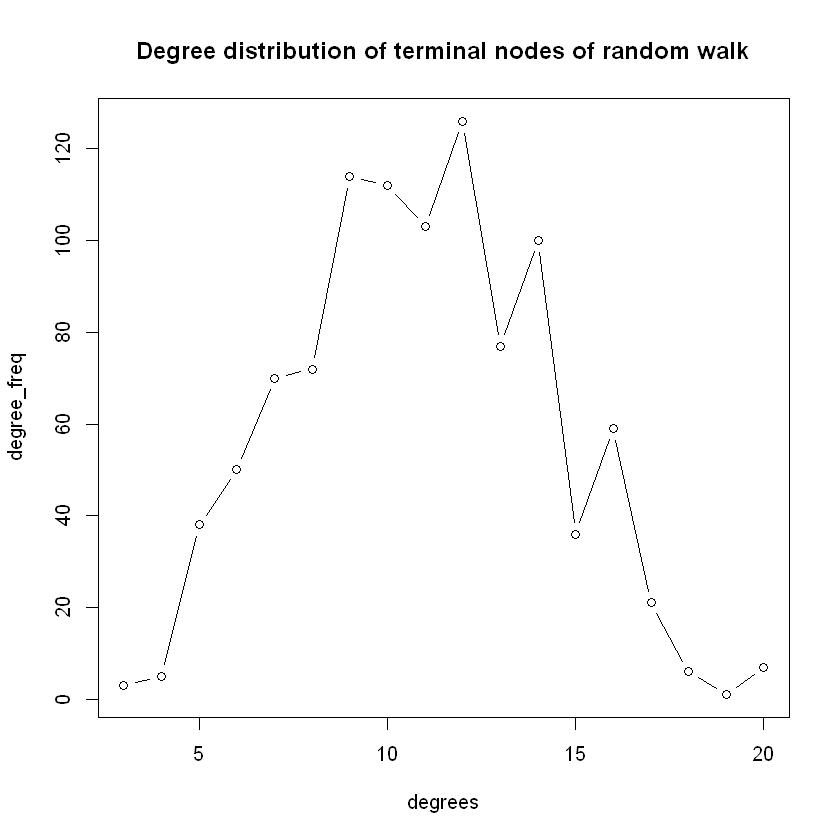

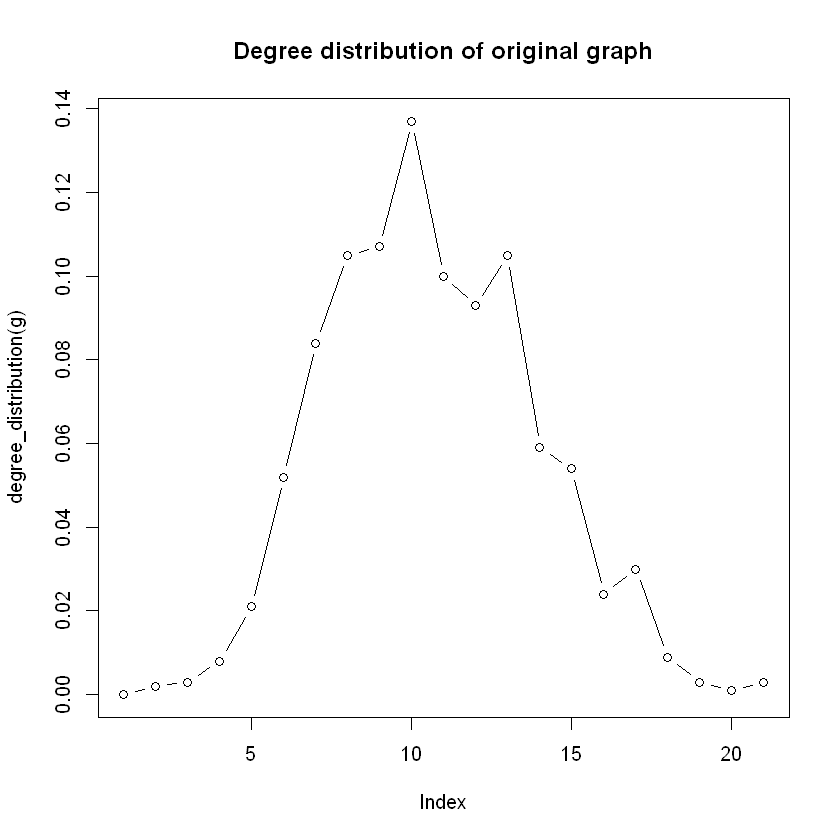

In [12]:
list[degrees, degree_freq] <- get_freq_distr(terminal_node_deg)
plot(degrees, degree_freq, type="b", main="Degree distribution of terminal nodes of random walk")
plot(degree_distribution(g), type="b", main="Degree distribution of original graph")

## (d)

In [14]:
g1 <- sample_gnp(n=10000, p=0.01, directed=F)

In [15]:
list[shortest_dists1, terminal_node_deg1] <- perform_random_walk(g1)

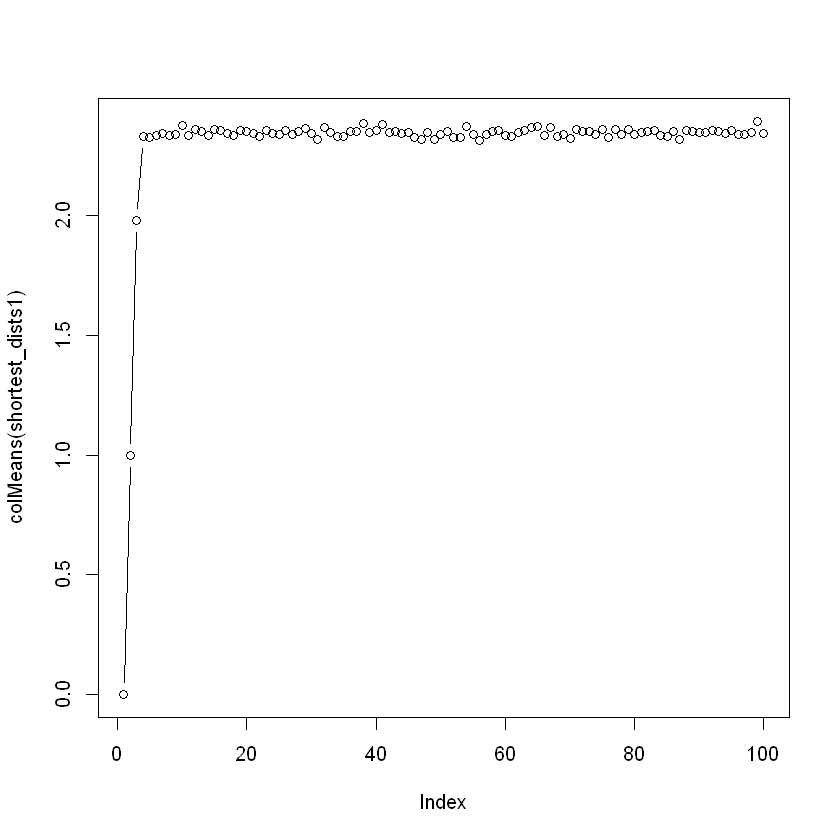

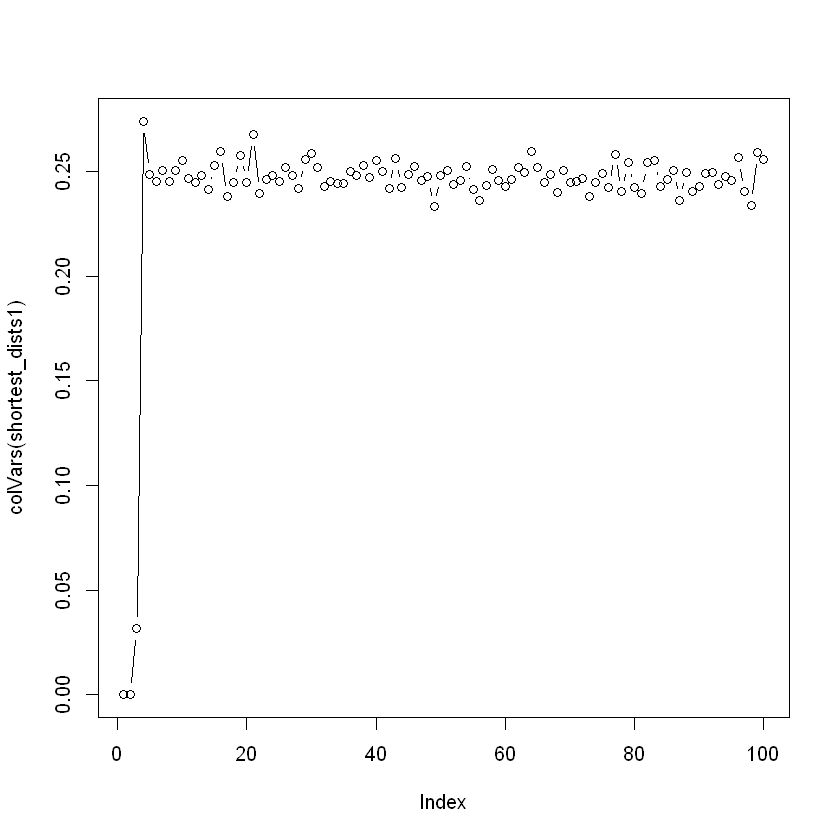

In [16]:
plot(colMeans(shortest_dists1), type="b")
plot(colVars(shortest_dists1), type="b")

## Q2

## (a)

In [23]:
g <- sample_pa(n=1000, m=1, directed=F)

## (b)

In [24]:
list[shortest_dists, terminal_node_deg] <- perform_random_walk(g)

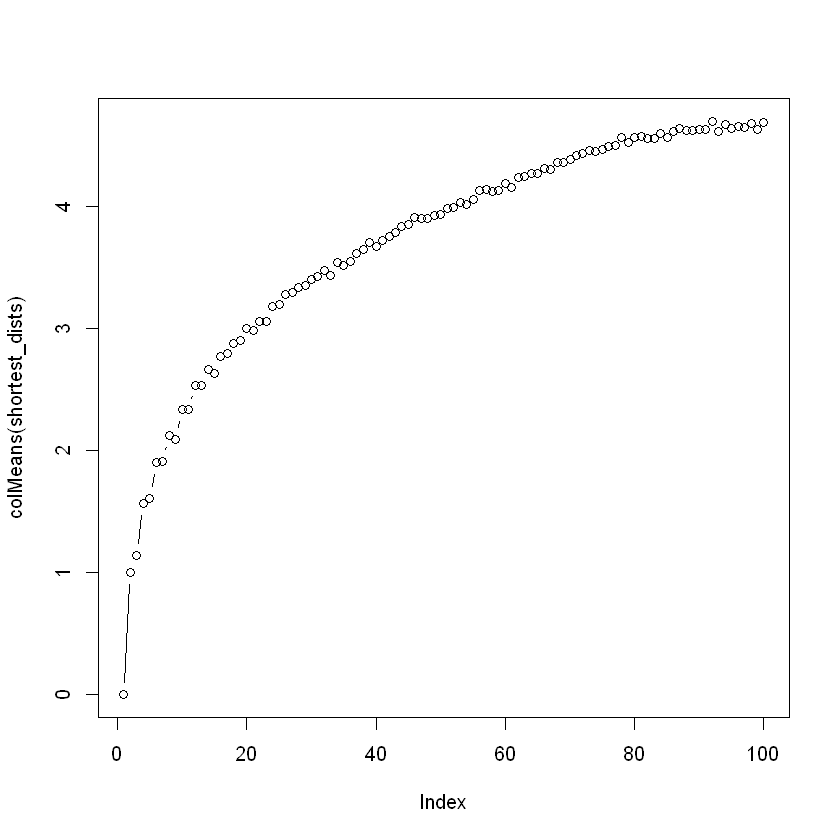

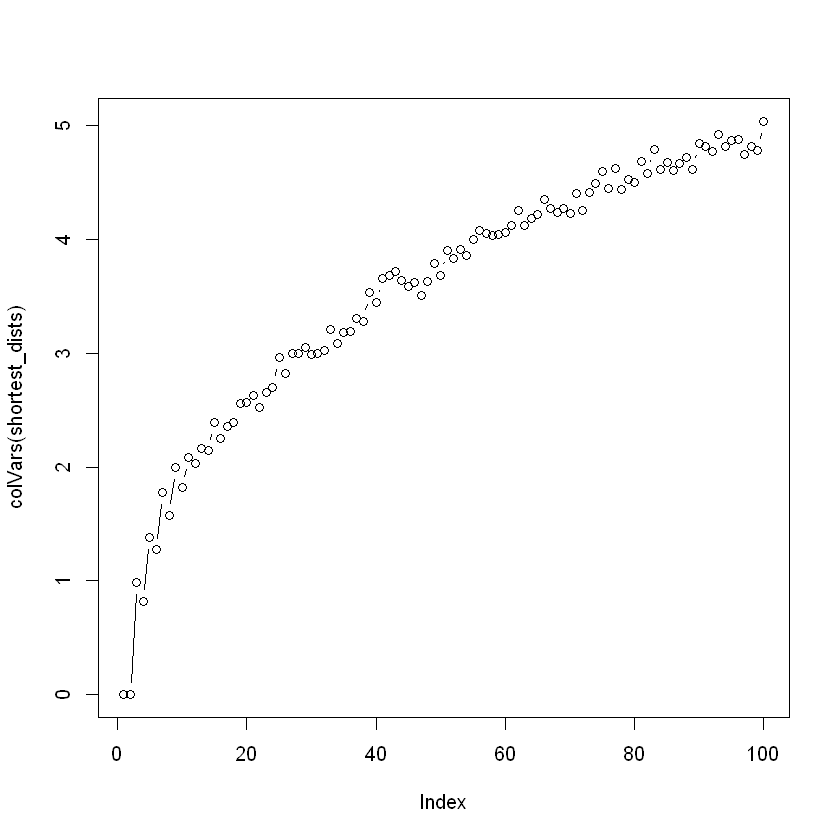

In [25]:
plot(colMeans(shortest_dists), type="b")
plot(colVars(shortest_dists), type="b")

## (c)

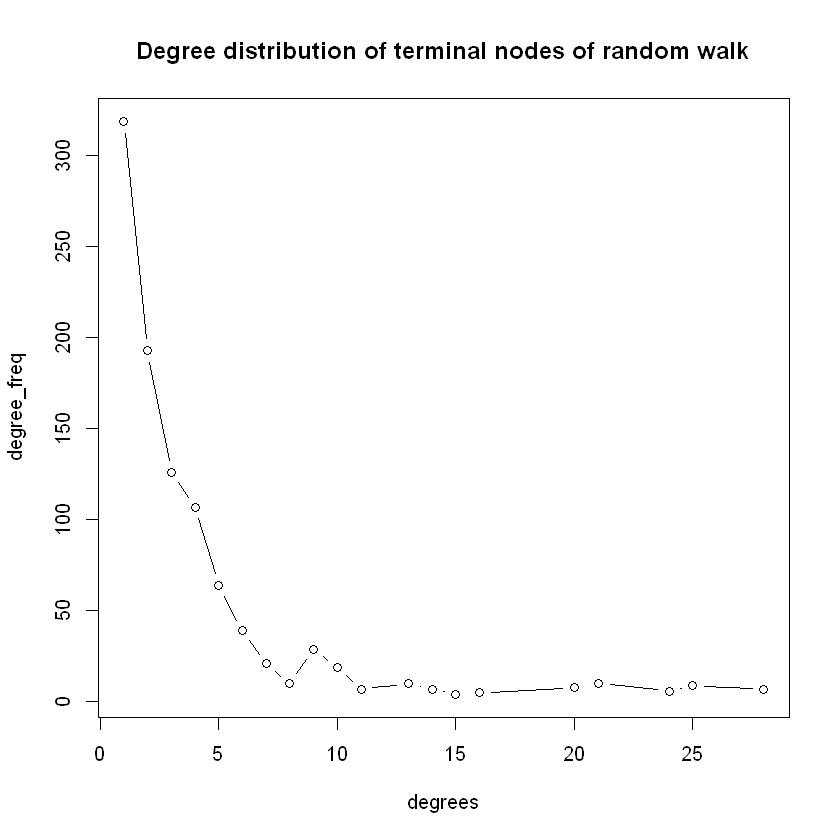

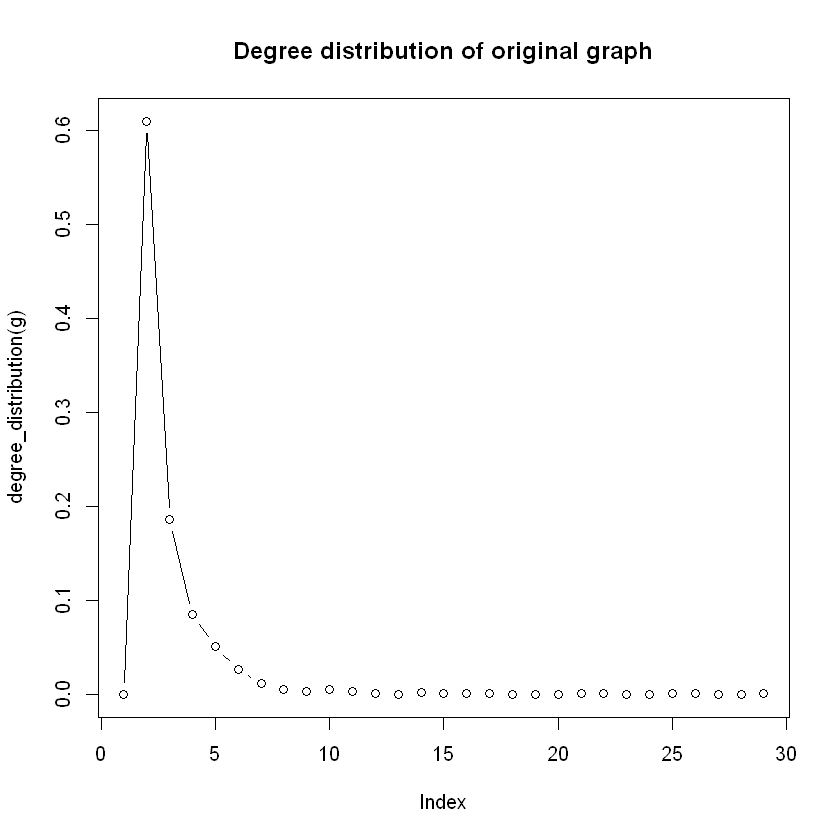

In [26]:
list[degrees, degree_freq] <- get_freq_distr(terminal_node_deg)
plot(degrees, degree_freq, type="b", main="Degree distribution of terminal nodes of random walk")
plot(degree_distribution(g), type="b", main="Degree distribution of original graph")

#### (d)

In [27]:
gg1 <- sample_pa(n=100, m=1, directed=F)
gg2 <- sample_pa(n=10000, m=1, directed=F)

In [28]:
list[shortest_dists11, terminal_node_deg11] <- perform_random_walk(gg1)
list[shortest_dists22, terminal_node_deg22] <- perform_random_walk(gg2)

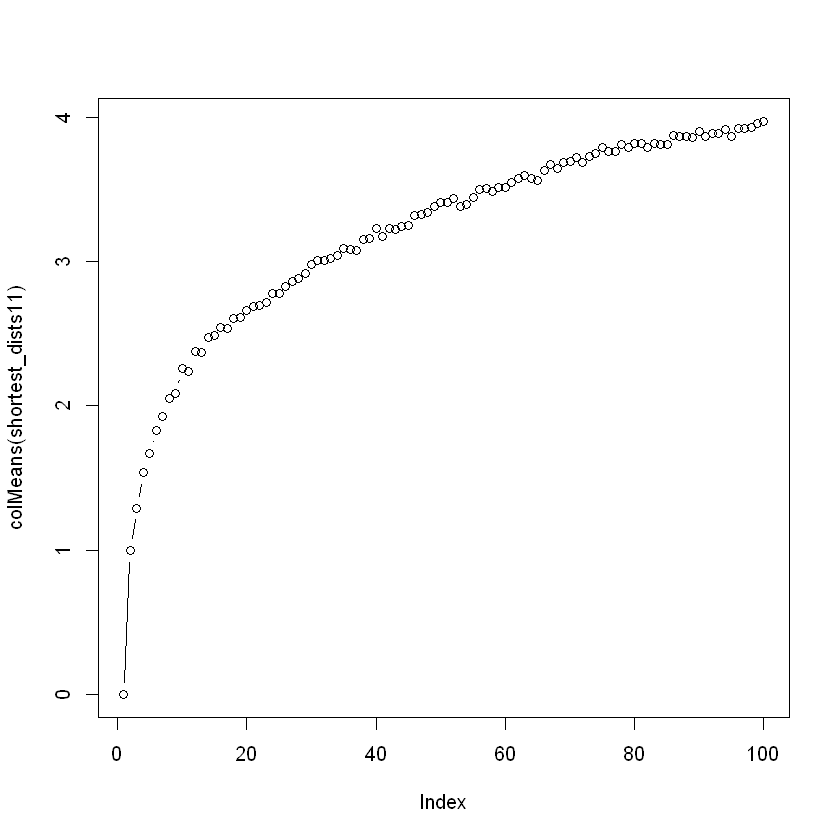

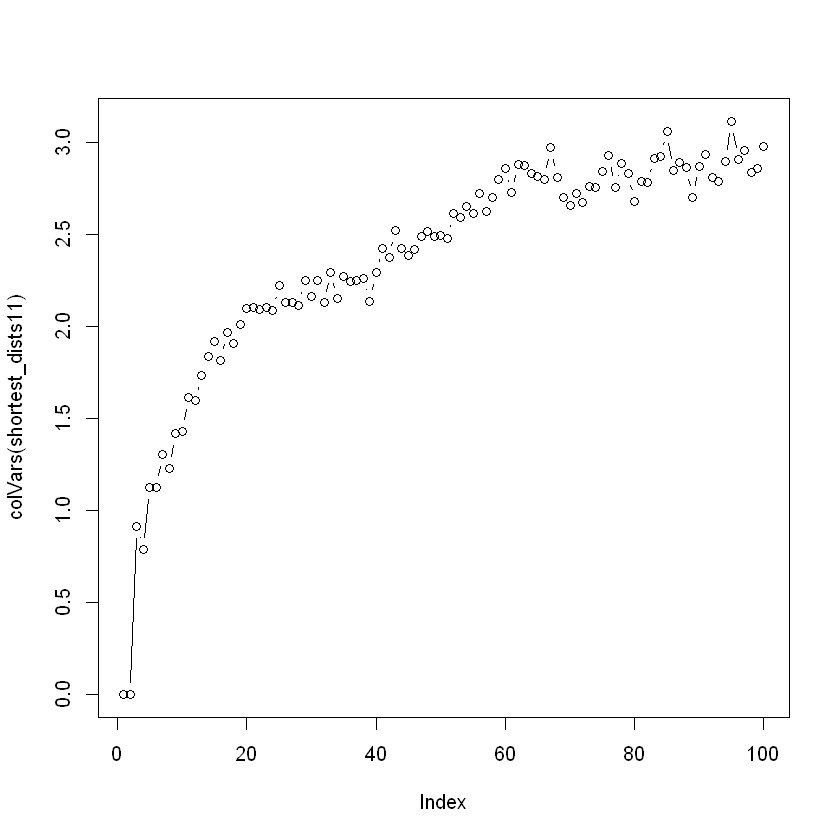

In [29]:
plot(colMeans(shortest_dists11), type="b")
plot(colVars(shortest_dists11), type="b")

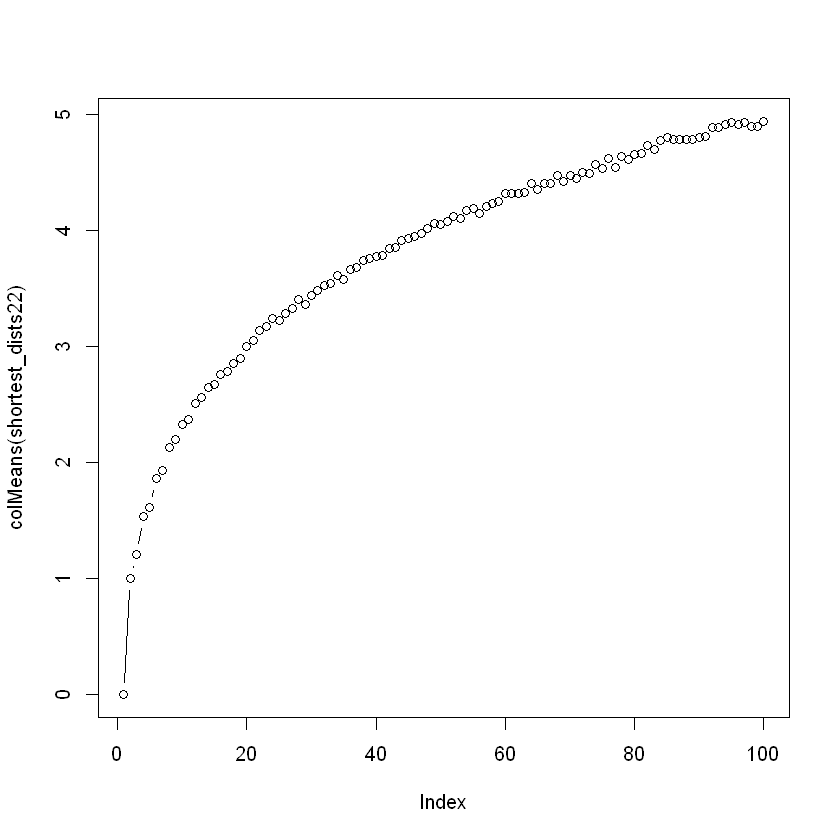

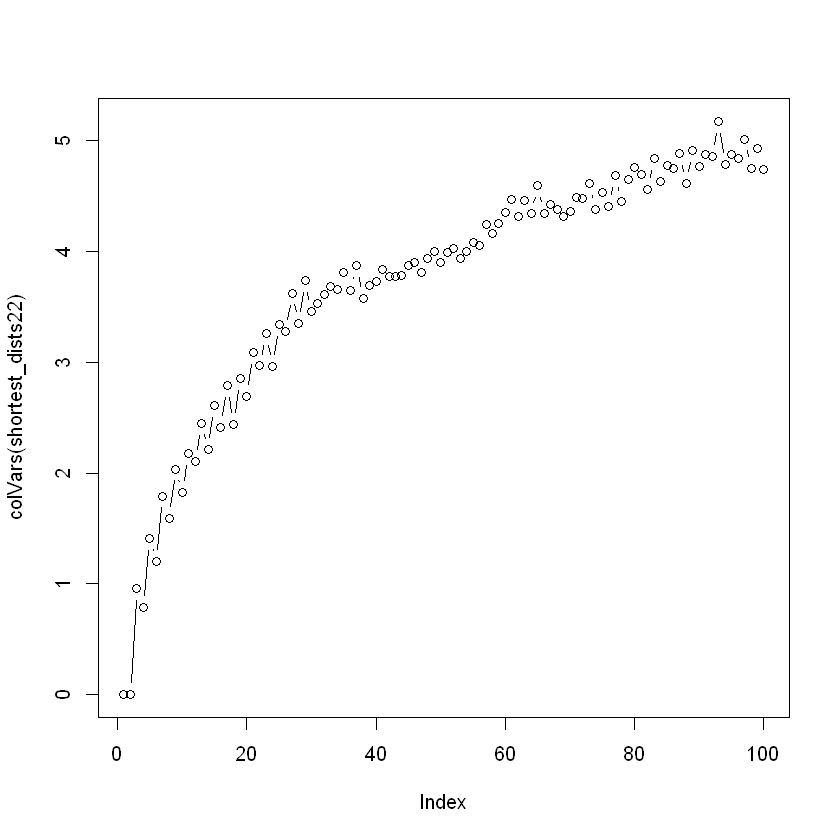

In [30]:
plot(colMeans(shortest_dists22), type="b")
plot(colVars(shortest_dists22), type="b")

## Q3

#### (a)

In [31]:
g1 <- sample_pa(n=1000, m=4, directed=T)
g2 <- sample_pa(n=1000, m=4, directed=T)

In [32]:
g2p <- permute(g2, sample(vcount(g2)))

In [33]:
g11 = add_edges(g1, c(t(as_edgelist(g2p))))

In [34]:
print(ecount(g11))

[1] 7980


In [35]:
iters=1000
steps=100
n_node_visits=array(0, vcount(g11))
for(i in 1:iters){
    #gcc <- get_gcc(g1)
    #print(V(gcc))
    #start_vert = sample(V(gcc), 1)
    start_vert = sample(V(g11), 1)
    vert_seq = random_walk(g11, start_vert, steps, mode="out")
    n_node_visits[unique(vert_seq)] = n_node_visits[unique(vert_seq)] + 1
}

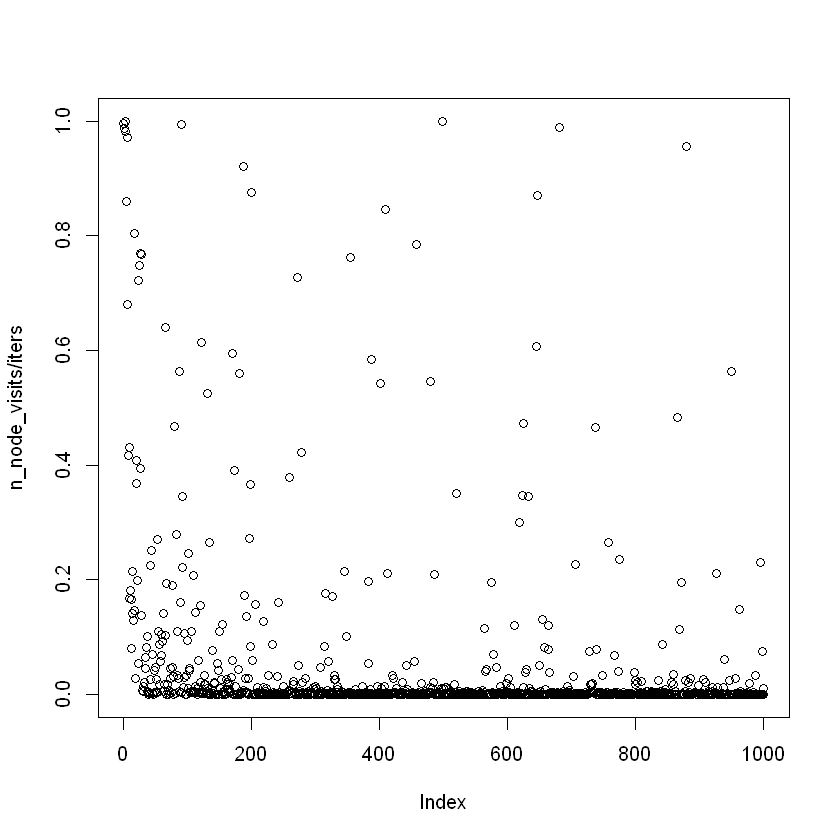

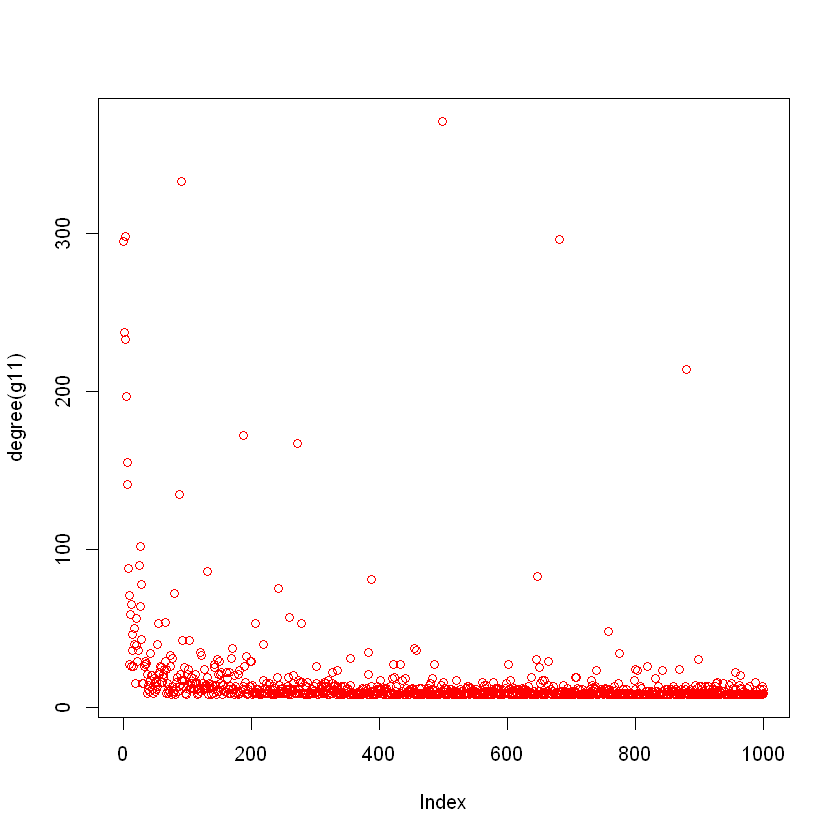

In [36]:
plot(n_node_visits/iters)
plot(degree(g11),col="red")

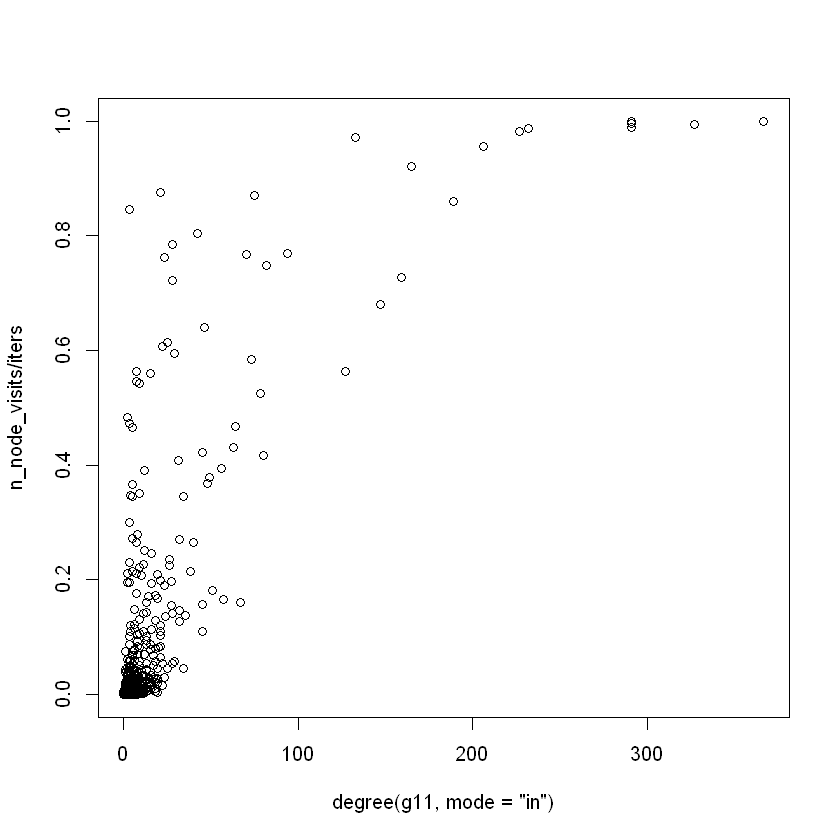

In [37]:
plot(degree(g11, mode="in"), n_node_visits/iters)

#### (b)

In [38]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    if(!is_connected(g)){
        print("Not connected")
    }
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

In [39]:
random_walk_custom = function (g, num_steps, start_node, transition_matrix = NULL, teleportation=0.0, teleport_visit_mode="equal"){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    vert_seq = array(NA, length(num_steps))
    
    switch(teleport_visit_mode, 
    "equal"={
        visit_probs=array(1/vcount(g), vcount(g))
    },
    "pg"={
        pg_ranks=page_rank(g, directed=T)$vector
        visit_probs=pg_ranks/sum(pg_ranks)   
    },
    "pg_median"={
        pg_ranks=page_rank(g, directed=T)$vector
        df = data.frame("idx"=1:vcount(g), "val"=pg_ranks)
        df=df[order(df$val),]
        visit_probs=array(0, vcount(g))
        mid=vcount(g) %/% 2
        visit_probs[df$idx[mid:mid+1]]=0.5
    },
    {
       visit_probs=array(1/vcount(g), vcount(g))
    }
    )
    
    
    
    
    for(i in 1:num_steps){
        #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        if(runif(1)<teleportation || degree(g, v, mode="out") == 0){
            v = sample(1:vcount(g), 1, prob = visit_probs)   
        }
        else{
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob = PMF)   
        }     
        vert_seq[i] = v
    }
    
    return(vert_seq)
}

In [48]:
perform_random_walk_custom = function(g, steps, iters, teleportation=0.15, teleport_visit_mode="equal"){
    n_node_visits=array(0, vcount(g))
    for(i in 1:iters){
        start_vert = sample(1:vcount(g), 1)
        vert_seq = random_walk_custom(g, steps, start_vert, teleportation=teleportation, teleport_visit_mode=teleport_visit_mode)
        n_node_visits[unique(vert_seq)] = n_node_visits[unique(vert_seq)] + 1
    }
    return (n_node_visits)
}

In [40]:
set.seed(1)

In [47]:
iters=1000
steps=100
alpha=0.15

In [49]:
n_node_visits=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="equal")

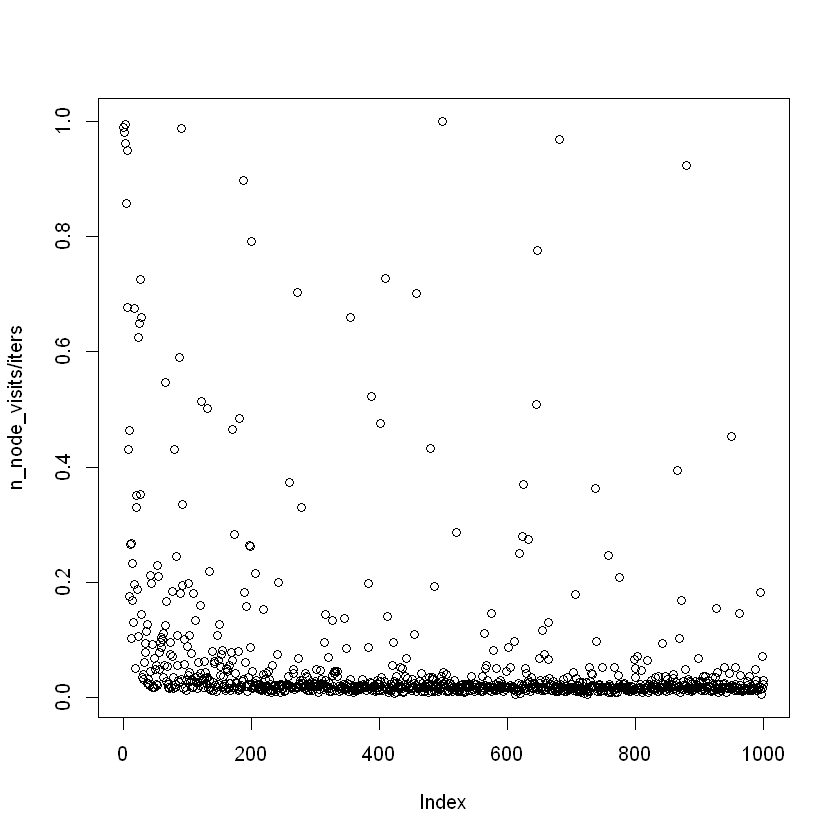

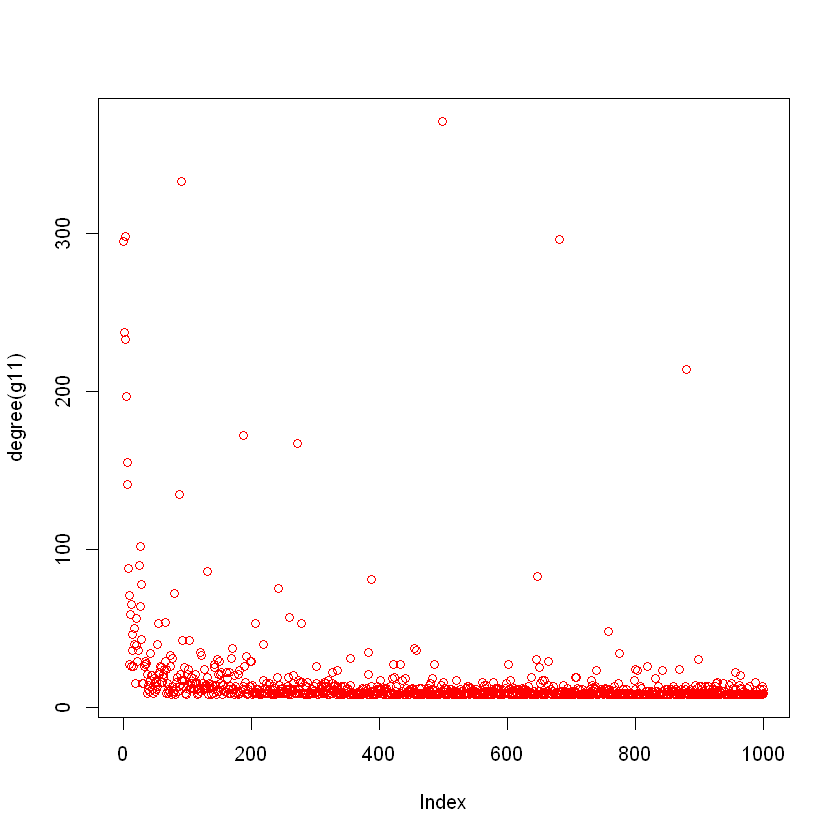

In [50]:
plot(n_node_visits/iters)
plot(degree(g11),col="red")

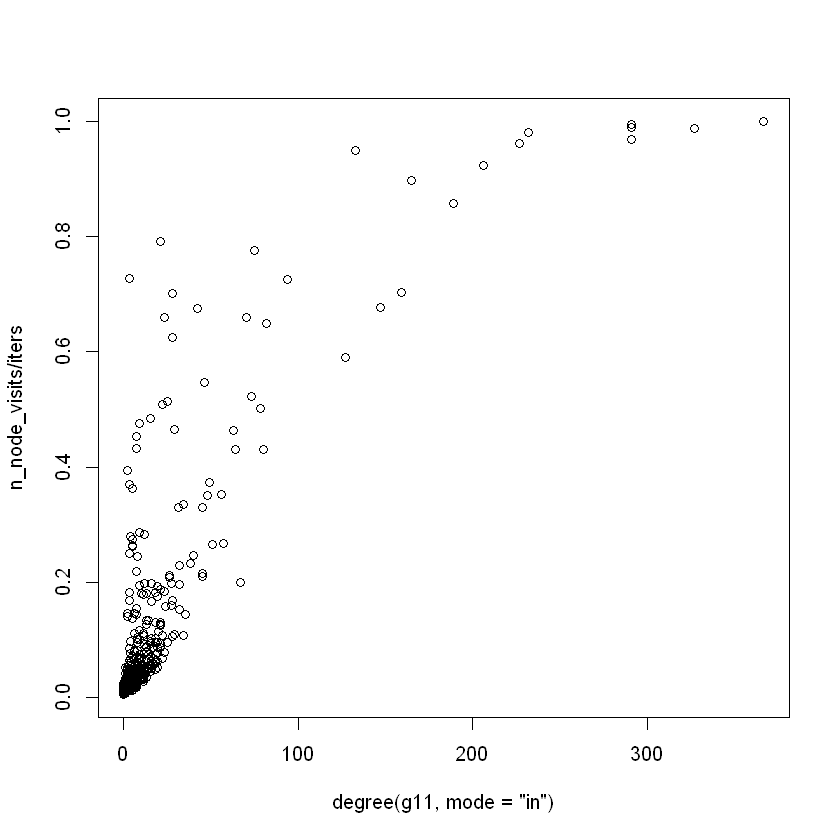

In [51]:
plot(degree(g11, mode="in"), n_node_visits/iters)

## Q4

#### (a)

In [53]:
n_node_visits=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg")

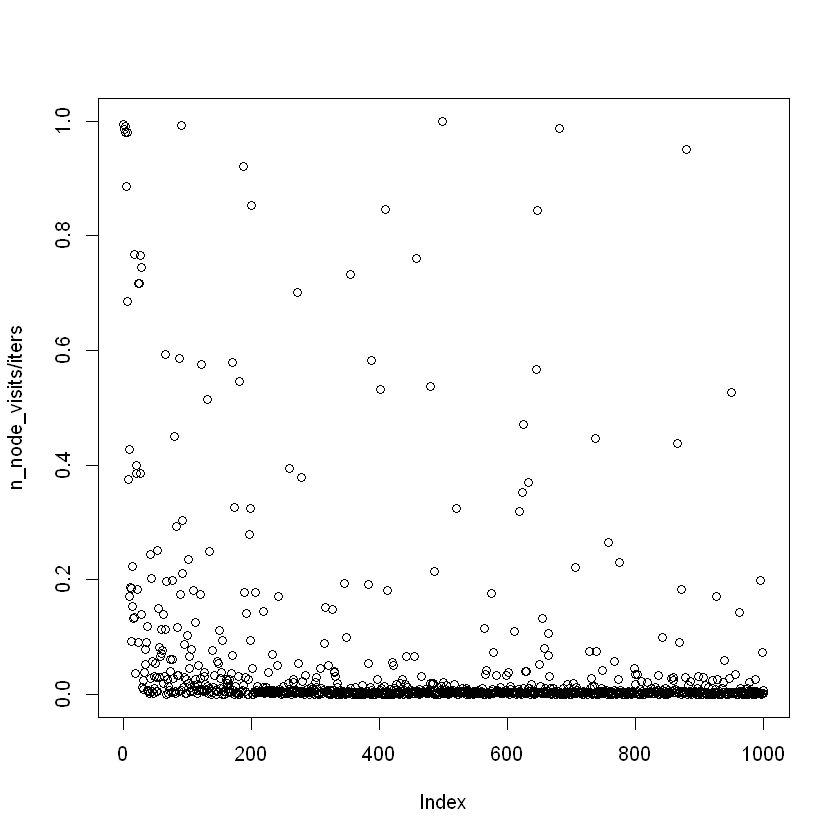

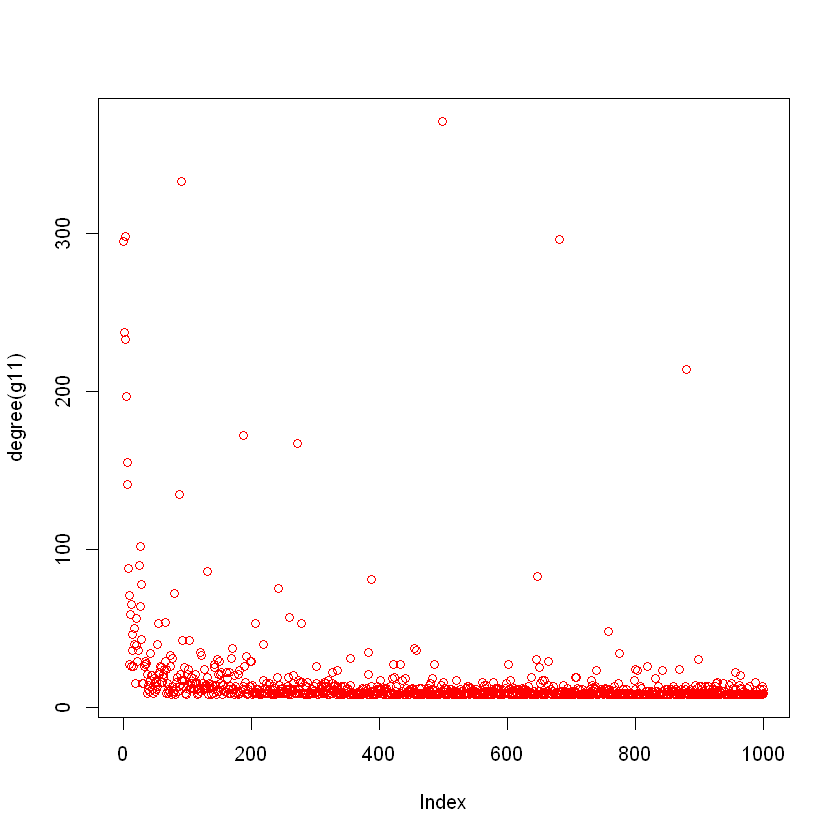

In [54]:
plot(n_node_visits/iters)
plot(degree(g11),col="red")

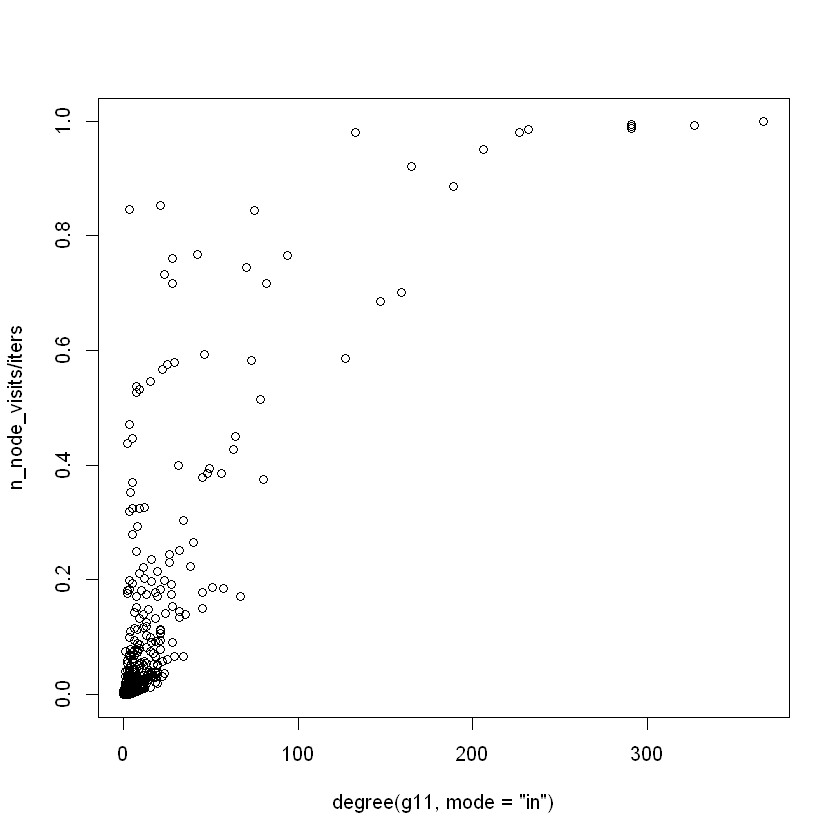

In [55]:
plot(degree(g11, mode="in"), n_node_visits/iters)

#### (b)

In [56]:
n_node_visits=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg_median")

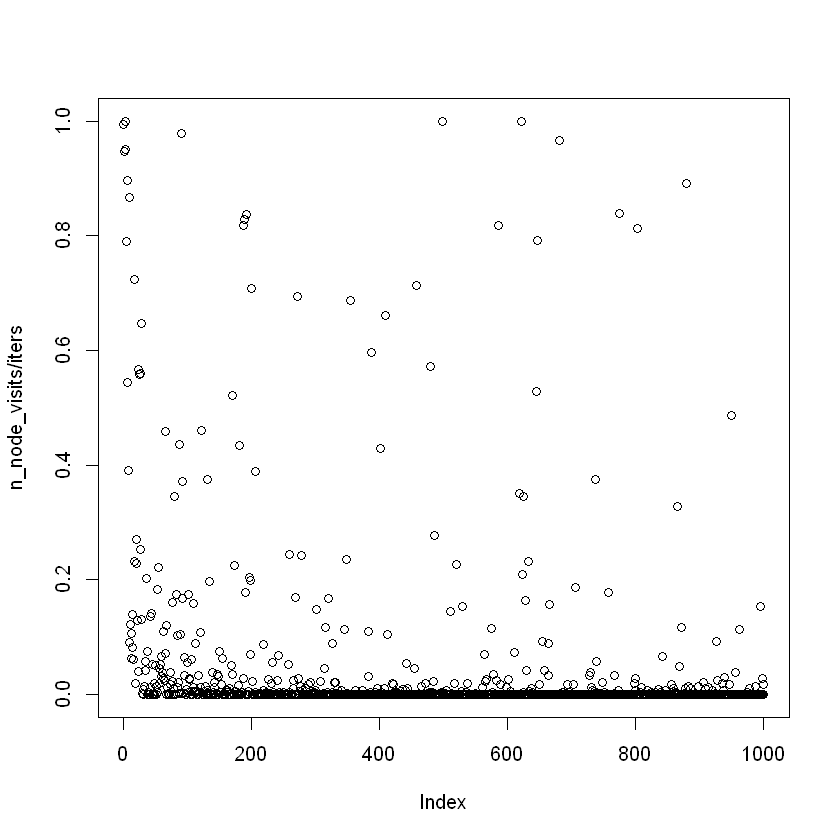

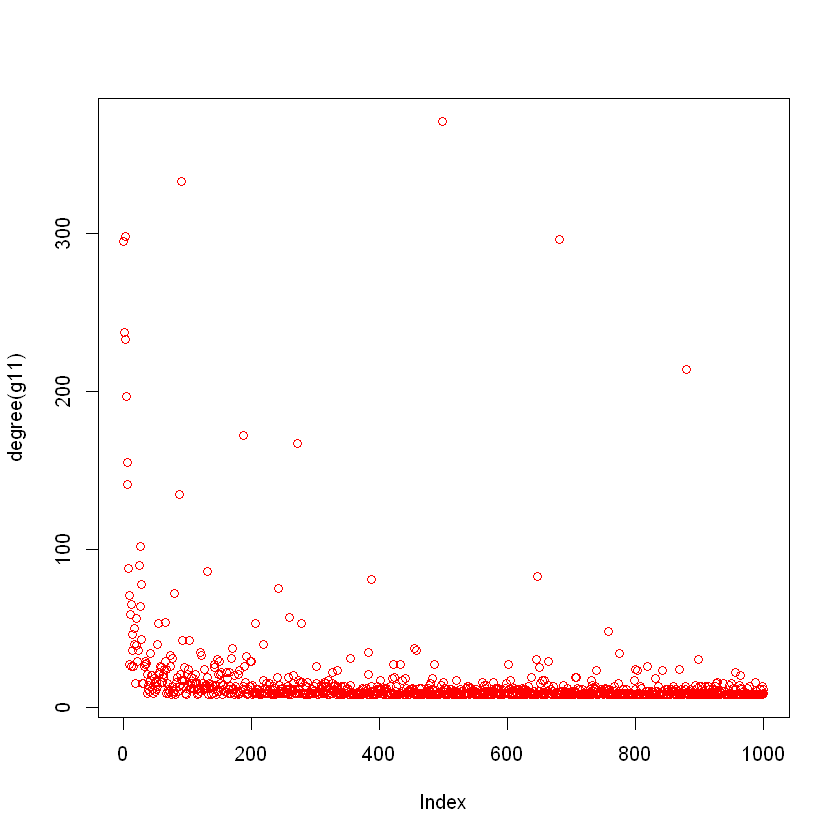

In [57]:
plot(n_node_visits/iters)
plot(degree(g11),col="red")

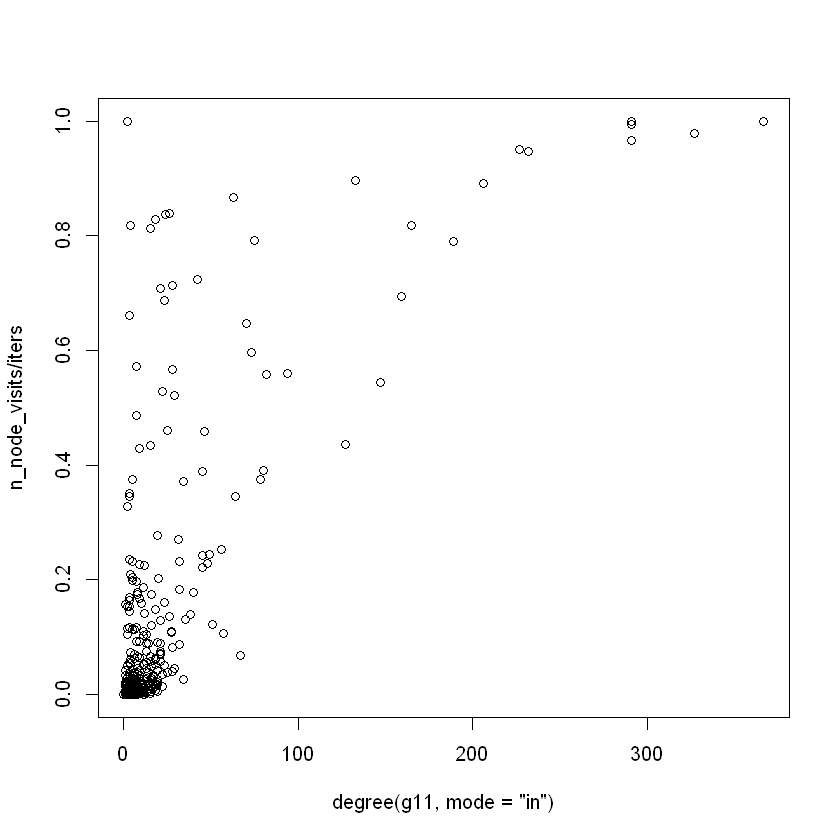

In [58]:
plot(degree(g11, mode="in"), n_node_visits/iters)